In [2]:
from model import NucleationGrowthModel, solve_agg, solve_nuc_gr_agg 
from rsc.utils import read_config, save_results

import numpy as np


config = read_config()
model = NucleationGrowthModel(config)

agg_sol = solve_agg(agg=model.K.k_agg, **config['sim_params']).sol

In [3]:
model.__init__(config)
results = solve_nuc_gr_agg(model, config, agg_sol)

save_results(results, model, config)

100%|█████████▉| 100/100 [00:00<00:00, 166it/s] 


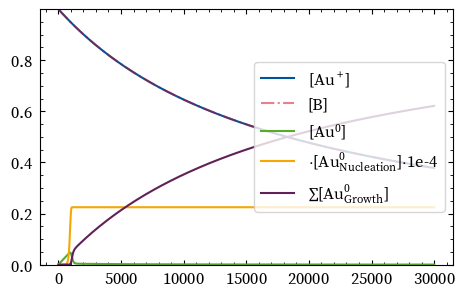

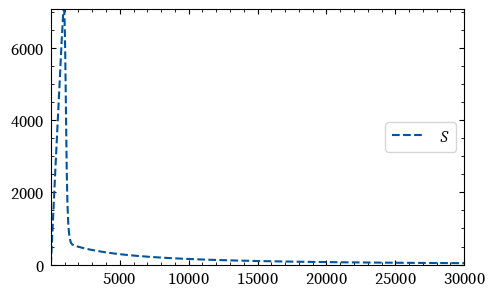

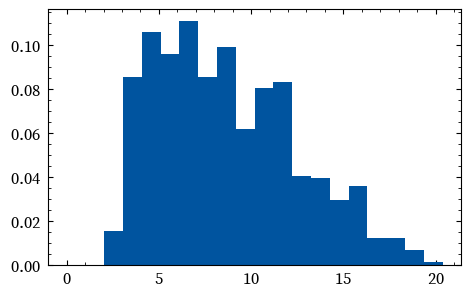

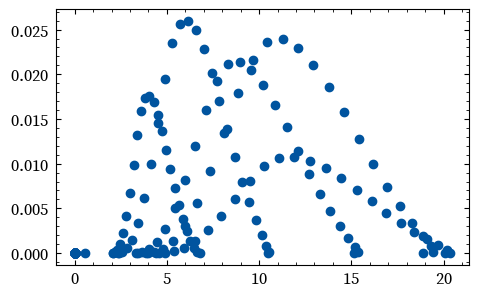

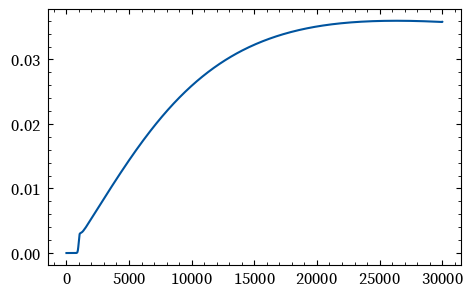

In [4]:
from plots import plot_defaults, time_vs_concentration, time_vs_saturation, number_vs_size, number_vs_size_scatter, time_vs_variance
from rsc import read_results

df = read_results("./results/DefaultParams_2023-02-24_07-04-31/data.h5")

plot_func = [time_vs_concentration, time_vs_saturation, number_vs_size, number_vs_size_scatter, time_vs_variance]

for funcs in plot_func:
    fig, gs = plot_defaults(1, 1)
    ax = fig.add_subplot(gs[0, 0])
    funcs(df, ax)


In [5]:
def execute_every_5_calls(func):
    def wrapper(*args, **kwargs):
        wrapper.num_calls += 1
        if wrapper.num_calls % 5 == 0:
            return func(*args, **kwargs)
    wrapper.num_calls = 0
    return wrapper

In [39]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import pandas as pd
import numpy as np

@execute_every_5_calls
def clear():
    clear_output()

def get_size(df):
    # Select columns corresponding to particle size R and number of particles P
    R_col = df.columns[df.columns.str.startswith('R')]
    P_col = df.columns[df.columns.str.startswith('P')]

    # Convert particle size to nanometers and extract data as numpy arrays
    R = df[R_col].to_numpy() * 1e9
    P = df[P_col].to_numpy()

    # Only include rows where there are non-zero number of particles
    cnd = P.sum(axis=1) > 0
    R = R[cnd]
    P = P[cnd]

    # Extract time values for plotting
    t = df.t[cnd]

    # Calculate weighted variance of particle size distribution
    weighted_avg = np.average(R, axis=1, weights=P)
    return t, weighted_avg


t_R, R, dr = np.loadtxt("data/Time_vs_radius1800.csv", delimiter=",").T
t, Var = np.loadtxt("data/Time_vs_pdi1800.csv", delimiter=",").T




def fit_size(x0, *args):
    gamma, E_1, E_gr, E_sol, E_agg = x0
    t_R, R = args
    model.config['const']['gamma'] = gamma
    model.config['activation']['E_1'] = E_1
    model.config['activation']['E_gr'] = E_gr
    model.config['activation']['E_sol'] = E_sol
    model.config['activation']['E_agg'] = E_agg
    model.__init__(config) # RESET MODEL INNIT
    results = solve_nuc_gr_agg(model, config, agg_sol)
    clear()
    df = pd.DataFrame(results, columns=model.columns)
    t, R_ode = get_size(df)
    R_dat = np.interp(t, t_R, R)

    print(f"Error: {np.sum((R_ode - R_dat)**2)}")
    error = np.sum((R_ode - R_dat)**2)
    return error
    

res = minimize(
    fit_size,
    x0=[245, 55, 45, 1, 90],
    args=(t_R, R),
    method='Nelder-Mead',
    bounds=[(210, 300),(35, 55), (20, 80), (0.1, 10), (10, 200)],
    options={'disp': True})









Error: 26.192030215605236


/tmp/ipykernel_20353/3042509174.py:59: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  res = minimize(


ValueError: too many values to unpack (expected 4)

In [44]:
gamma, E_1, E_gr, E_sol, E_agg = res.x
model.config['const']['gamma'] = gamma
model.config['activation']['E_1'] = E_1
model.config['activation']['E_gr'] = E_gr
model.config['activation']['E_sol'] = E_sol
model.config['activation']['E_agg'] = E_agg
model.__init__(config) # RESET MODEL INNIT
results = solve_nuc_gr_agg(model, config, agg_sol)


df = pd.DataFrame(results, columns=model.columns)
t, R_ode = get_size(df)

save_results(results, model, config)

  4%|▍         | 3.90/100 [00:00<00:02, 34.3it/s]


In [32]:
res.x

array([6.50000000e+01, 3.85682786e+01, 1.00000000e-01, 1.87527330e+02])

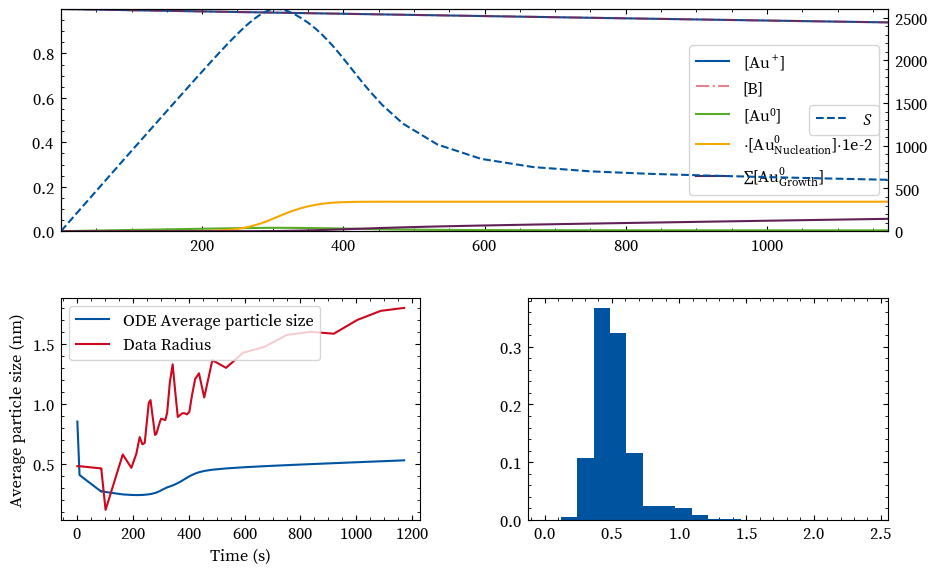

In [45]:
from plots import plot_defaults, time_vs_size, number_vs_size_scatter, time_vs_concentration, time_vs_saturation, number_vs_size, time_vs_variance

save_results(results, model, config)



df = read_results("./results/DefaultParams_2023-02-24_07-52-01/data.h5")



R_dat = np.interp(t, t_R, R)
fig, gs = plot_defaults(2, 2, 30)
# adjust subplot spacing
gs.update(wspace=0.3, hspace=0.3)
ax_top = fig.add_subplot(gs[0, :])
time_vs_concentration(df, ax_top)
ax_top_twin = ax_top.twinx()
time_vs_saturation(df, ax_top_twin)
ax_l = fig.add_subplot(gs[1, 0])
ax_r = fig.add_subplot(gs[1, 1])
time_vs_size(df, ax_l)
ax_l.plot(t, R_dat, label="Data Radius")
ax_l.legend()
number_vs_size(df, ax_r)


ax.legend()


No plot function defined for time_vs_PDI.
No plot function defined for R_vs_P_scatter.
No plot function defined for R_vs_P_histogram.


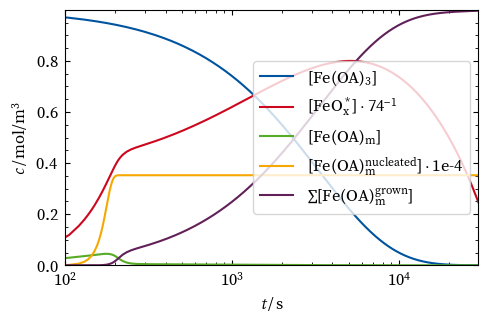

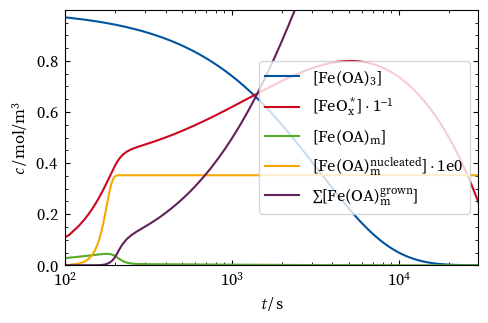

In [1]:
from rsc import read_results
from plots import PlotManager, Plot, time_vs_concentration, time_vs_saturation


df = read_results('./results/DefaultParams_2023-02-21_10-22-08/data.h5')


plots = [
    Plot('time_vs_concentration', 'time', 'conc', time_vs_concentration),
    Plot('time_vs_saturation', 'time', 'conc', time_vs_concentration),
    Plot('time_vs_PDI', 'time', 'pdi', None),
    Plot('R_vs_P_scatter', 'radius', 'number', None),
    Plot('R_vs_P_histogram', 'radius', 'number', None),
]
pm = PlotManager('/DefaultParams_2023-02-21_10-22-08/', plots)

pm.save_plots(df)

In [4]:
def plot_single(**kwargs):
    print(kwargs)
    return kwargs.get('xxlabel', '')
plot_single(xlabel='test')



{'xlabel': 'test'}


''

In [202]:

%matplotlib inline

from plots import num_vs_size_hist
from rsc import read_results

import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import quad
import numpy as np

def log_normal(x, mu, sig):
    f = 1 / (x * sig * (2 * np.pi)**0.5)

    exp = np.exp(
         - (np.log(x) - mu)**2 / 
         (2 * sig**2)
    )

    return f * exp

df = read_results('./results/DefaultParams_2023-02-21_10-22-08/data.h5')

mu_l = []
sig_l = []
for i in range(20, 1000):
    P_col, R_col = num_vs_size_hist(df, 1)

    R = df[P_col].iloc[i,:] * 1e9
    P = df[R_col].iloc[i,:]
    P = P



    #plt.hist(R , bins=20, weights=P, label='rel. freq. of Particle Size')



    #plt.hist(R , bins=10, weights=P, label='rel. freq. of Particle Size', density=True)

    bin_heights, bin_borders = np.histogram(R, bins=10, weights=P, density=True)
    bin_widths = np.diff(bin_borders)
    bin_centers = bin_borders[:-1] + bin_widths / 2
    popt, _ = curve_fit(log_normal, bin_centers, bin_heights, p0=[2.1, .1])

    #plt.plot(t, log_normal(t, *popt))
    mu, sig = popt
    mu_l.append(mu)
    sig_l.append(sig)

mu_l = np.array(mu_l)
sig_l = np.array(sig_l)


/home/ben/.conda/envs/py311/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [203]:
var = (np.exp(sig_l**2) - 1)*(np.exp(2*mu_l + sig_l**2))

/tmp/ipykernel_15593/2653151055.py:1: RuntimeWarning: overflow encountered in exp
  var = (np.exp(sig_l**2) - 1)*(np.exp(2*mu_l + sig_l**2))
/tmp/ipykernel_15593/2653151055.py:1: RuntimeWarning: overflow encountered in multiply
  var = (np.exp(sig_l**2) - 1)*(np.exp(2*mu_l + sig_l**2))


(0.0, 10.0)

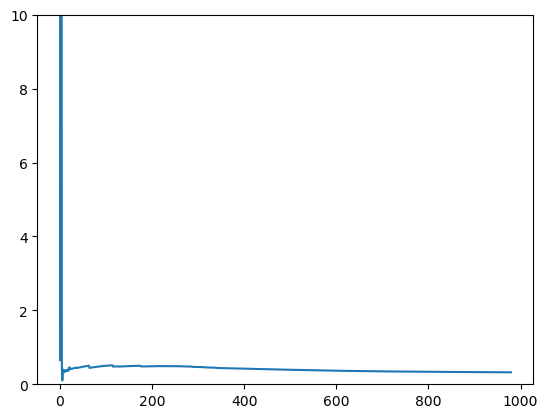

In [209]:
plt.plot(sig_l)
plt.ylim(0,10)

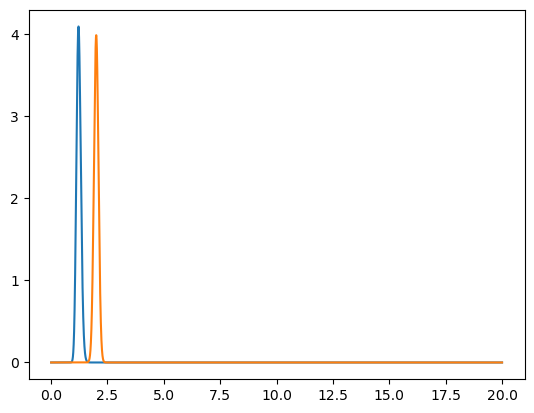

In [ ]:
def log_normal(x, mu, sig):
    x = np.array(x)
    f = 1 / (x * sig * (2 * np.pi)**0.5)

    exp = np.exp(
        - (np.log(x) - mu)**2 / 
        (2 * sig**2)
    )

    return f * exp

t = np.arange(0.001, 20, 0.001)
plt.plot(t, log_normal(t, 0.2, 0.08))
plt.plot(t, g(t, 2, 0.1))

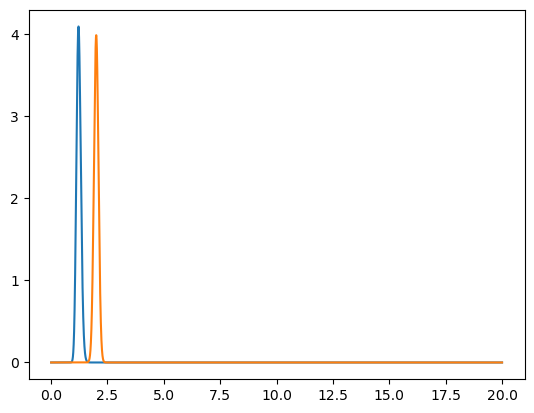

In [142]:
def log_normal(x, mu, sig):
    x = np.array(x)
    f = 1 / (x * sig * (2 * np.pi)**0.5)

    exp = np.exp(
        - (np.log(x) - mu)**2 / 
        (2 * sig**2)
    )

    return f * exp

t = np.arange(0.001, 20, 0.001)
plt.plot(t, log_normal(t, 0.2, 0.08))
plt.plot(t, g(t, 2, 0.1))

In [76]:
a

(nan, nan)

In [73]:
from scipy.optimize import curve_fit

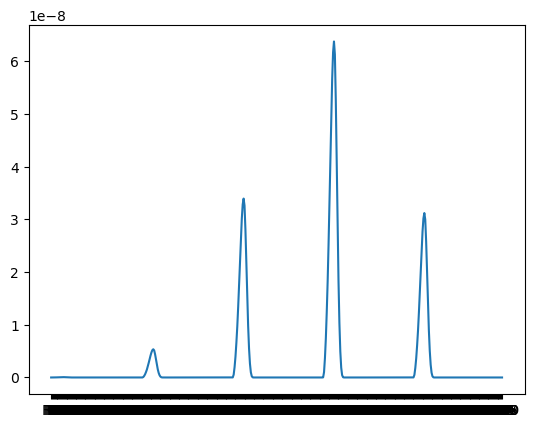

In [ ]:
%matplotlib inline

from plots import num_vs_size_hist
from rsc import read_results

import matplotlib.pyplot as plt

df = read_results('./results/DefaultParams_2023-02-21_10-22-08/data.h5')

P_col, R_col = num_vs_size_hist(df, 1)

plt.plot(df[R_col].iloc[-1,:])